In [ ]:
import gym
import warnings
import numpy as np
import seaborn as sns
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import tqdm
from TRPO import TRPO

warnings.filterwarnings("ignore")

In [2]:
def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')


def plot_weight_distribution(model):
    plt.figure(figsize=(12, 4), dpi=400)

    for name, param in model.named_parameters():
        if "weight" in name:
            sns.histplot(param.data.cpu().numpy().flatten(), bins=100, kde=True, label=name)

    plt.title("Weight Distribution of DQN")
    plt.xlabel("Weight Values")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

In [3]:
# 환경 설정
env = gym.make("CartPole-v1")
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

model = TRPO(state_dim=state_dim, action_dim=action_dim)
model.v.apply(initialize_weights)
model.pi.apply(initialize_weights)

T = 500  # T는 몇 타임스탭 동안 data를 모을지
rewards_log = []

for n_epi in tqdm(range(1000)):
    s, _ = env.reset()
    total_reward = 0.0
    step_count = 0

    for t in range(T):
        a, prob = model.select_action(s, rewards_log)
        s_prime, r, terminated, truncated, info = env.step(a)
        done = truncated or terminated

        decreasing_reward = r * (0.99 ** step_count)
        step_count += 1

        # prob -> 실제 한 action의 확률값 나중에 ratio 계산에 쓰임
        # 나중에 PPO에서 old policy 의 확률값 사용함.
        model.put_data((s, a, decreasing_reward, s_prime, prob, done))
        s = s_prime

        total_reward += r

        if done:
            break

    if len(rewards_log) < 10 or np.mean(rewards_log[-10:]) < 450:
        model.train()


    else:
        print('optimal')

    rewards_log.append(total_reward)

env.close()

  1%|          | 9/1000 [00:00<01:12, 13.73it/s]

tensor(-0.0031, device='cuda:0') tensor(0.0010, device='cuda:0')
tensor(-0.1604, device='cuda:0') tensor(0.0010, device='cuda:0')
tensor(-0.3744, device='cuda:0') tensor(0.0010, device='cuda:0')


 24%|██▎       | 235/1000 [00:11<00:38, 20.01it/s]

tensor(-1.0643, device='cuda:0') tensor(0.0010, device='cuda:0')


100%|██████████| 1000/1000 [00:52<00:00, 19.09it/s]


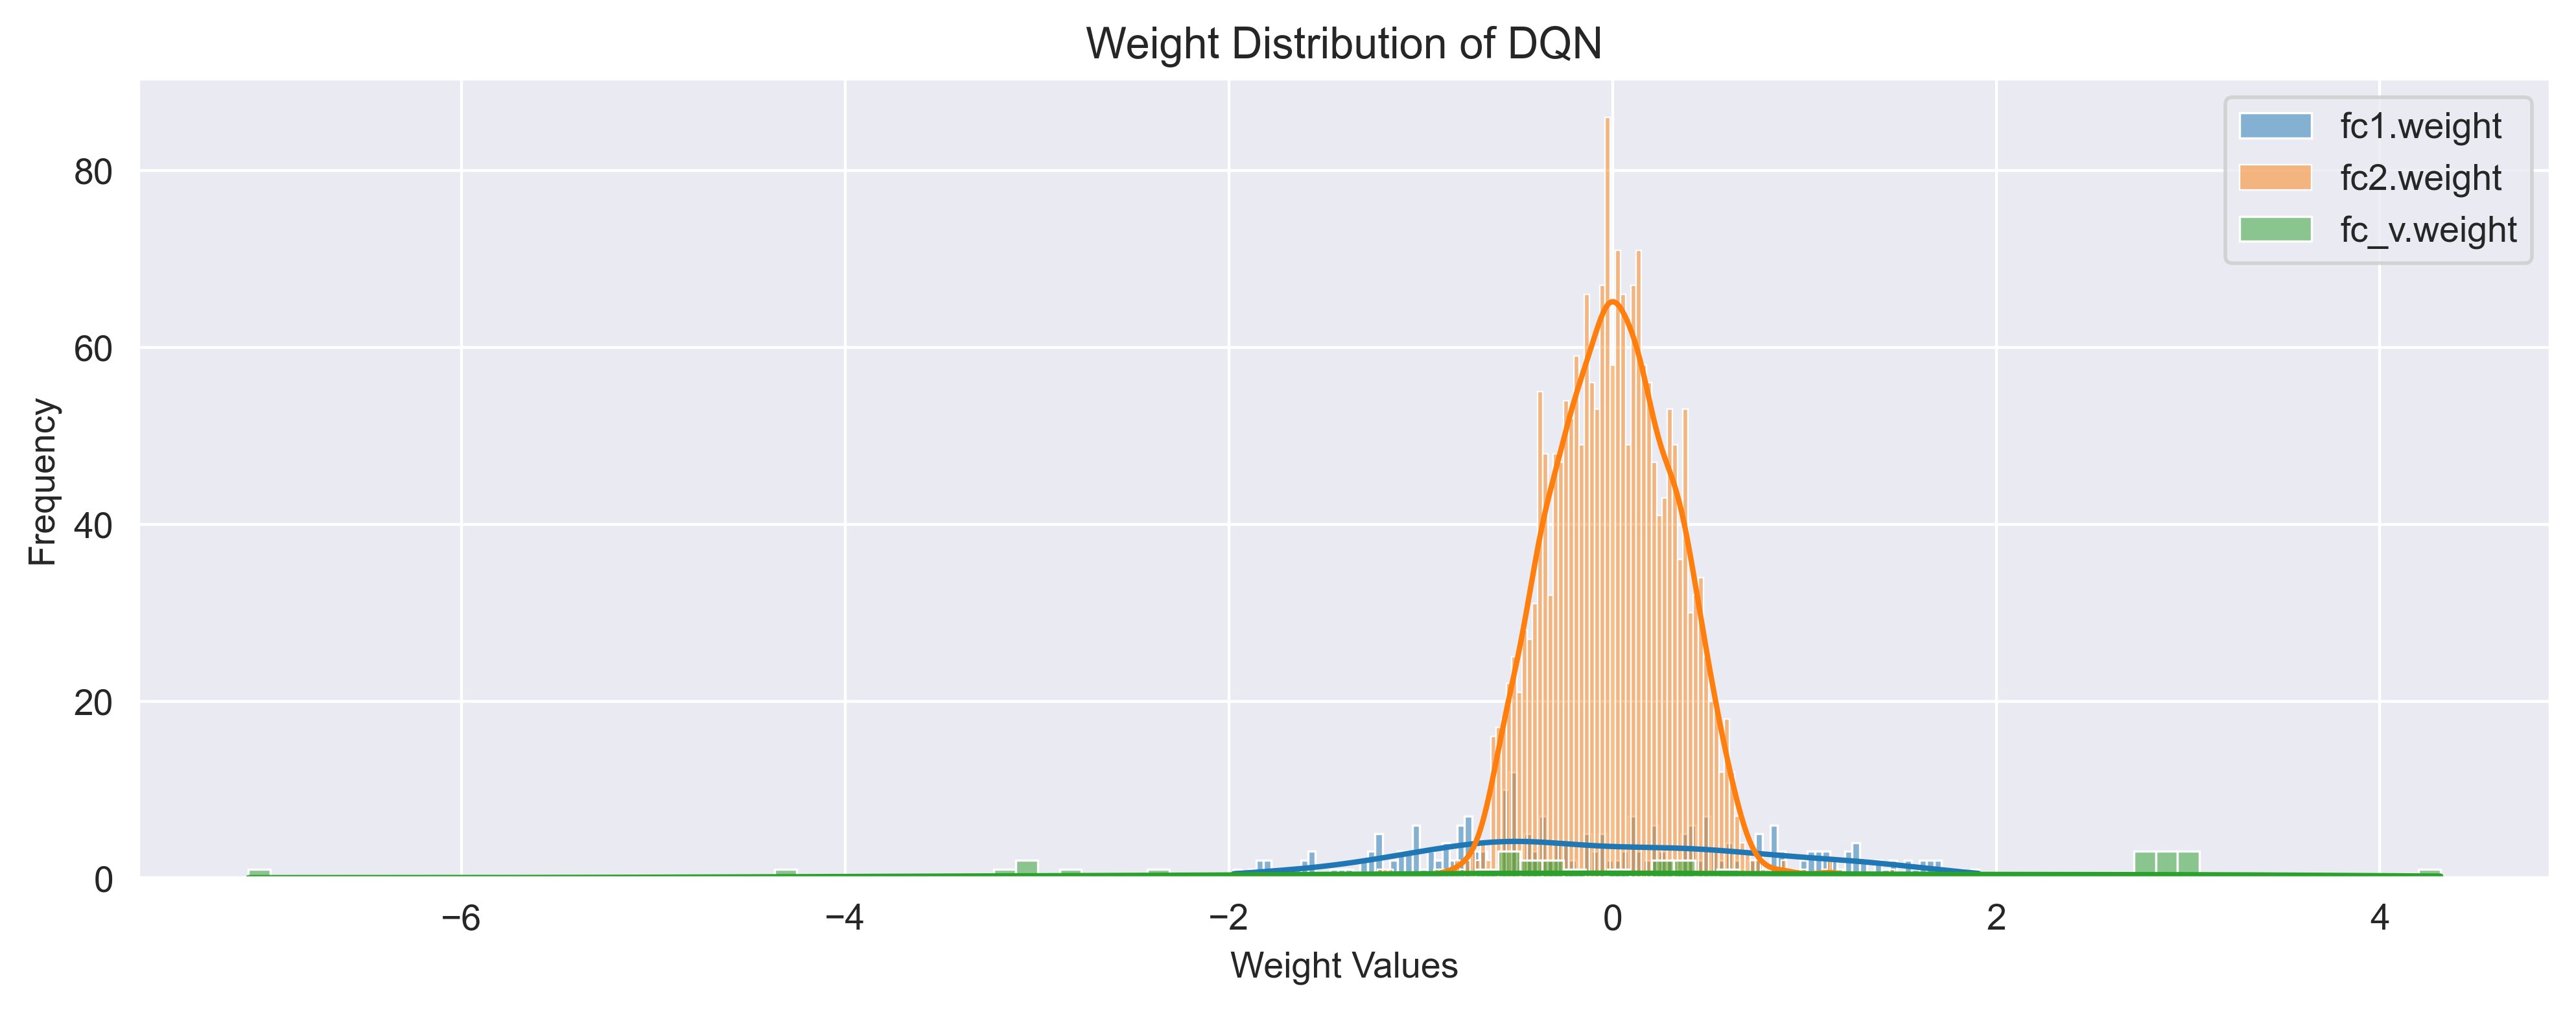

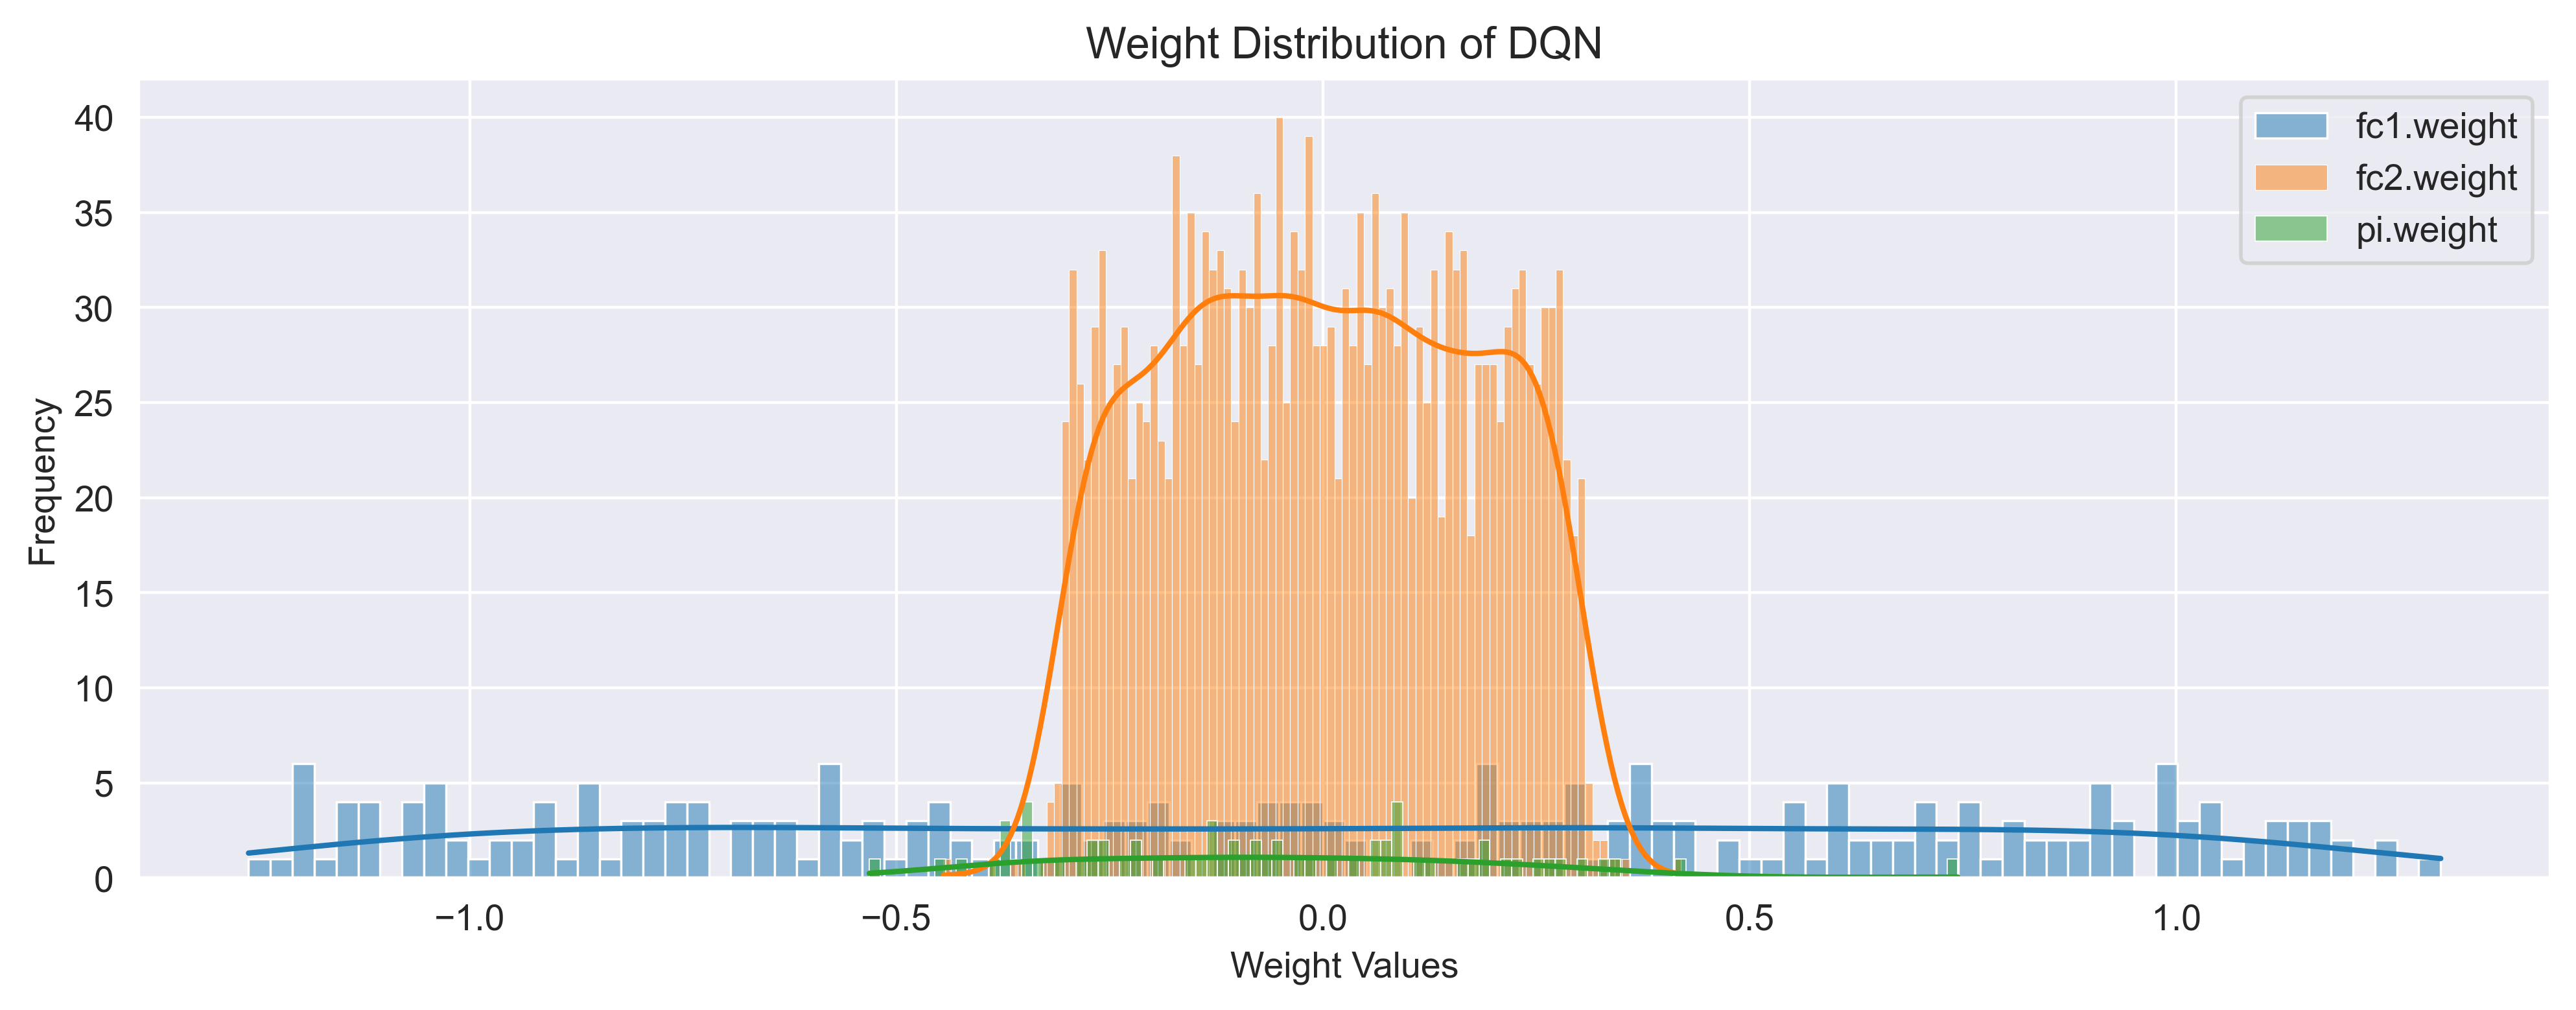

In [4]:
# 현재 policy_net의 가중치 분포 확인
plot_weight_distribution(model.v)
plot_weight_distribution(model.pi)

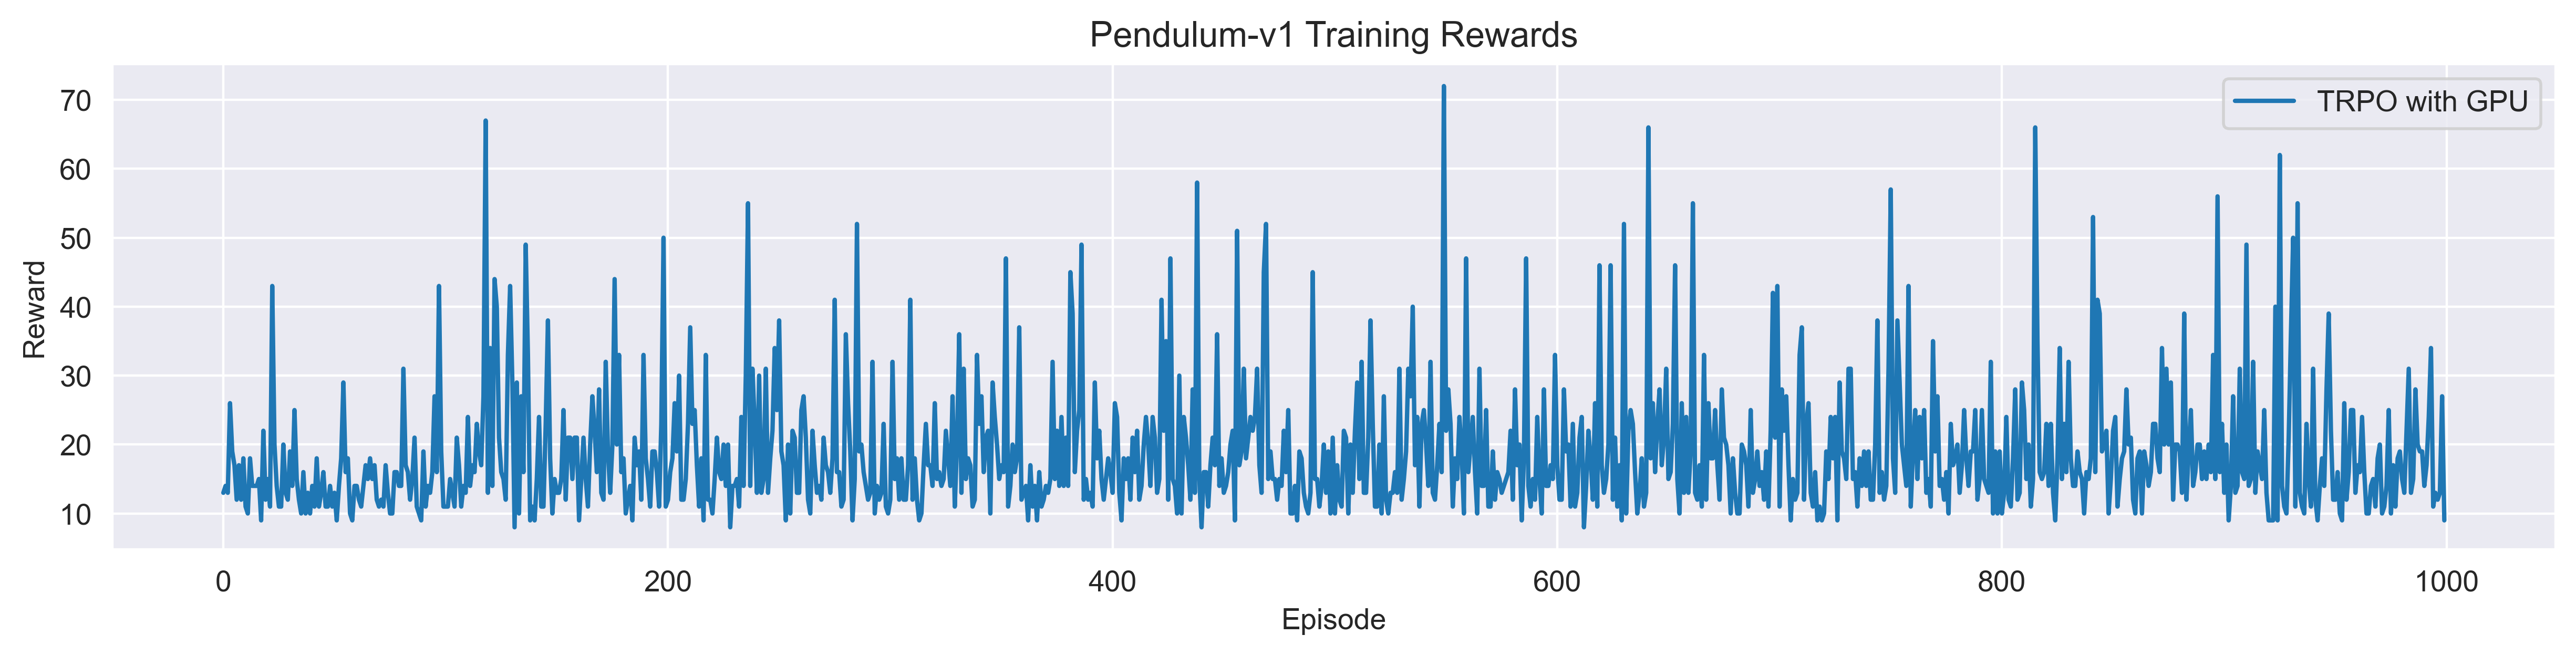

First 10 episode rewards: [13.0, 14.0, 13.0, 26.0, 19.0, 17.0, 12.0, 17.0, 12.0, 18.0]
Last 10 episode rewards: [14.0, 17.0, 24.0, 34.0, 11.0, 13.0, 12.0, 13.0, 27.0, 9.0]
Average reward over last 100 episodes: 18.51


In [5]:
# 학습 결과 시각화
plt.figure(figsize=(15, 3), dpi=400)
plt.plot(rewards_log, label="TRPO with GPU")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("Pendulum-v1 Training Rewards")
plt.legend(loc="upper right")
plt.show()

print("First 10 episode rewards:", rewards_log[:10])
print("Last 10 episode rewards:", rewards_log[-10:])
print(f"Average reward over last 100 episodes: {np.mean(rewards_log[-100:]):.2f}")